In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

#### Context
High precision and reliable wind speed forecasting is a challenge for meteorologists. Severe wind due to convective storms, causes considerable damages (large scale forest damage, outage, buildings/houses damage, etc.). Convective events such as thunderstorms, tornadoes as well as large hail, strong winds, are natural hazards that have the potential to disrupt daily life, especially over complex terrain favoring the initiation of convection. Even ordinary convective events produce severe winds which causes fatal and costly damages. Therefore, wind speed prediction is an important task to get advanced severe weather warning. This dataset contains the responses of a weather sensor that collected different weather variables such as temperatures and precipitation.

#### Content
The dataset contains 6574 instances of daily averaged responses from an array of 5 weather variables sensors embedded in a meteorological station. The device was located on the field in a significantly empty area, at 21M. Data were recorded from January 1961 to December 1978 (17 years). Ground Truth daily averaged precipitations, maximum and minimum temperatures, and grass minimum temperature were provided.

#### Attribute Information
- DATE (YYYY-MM-DD)
- WIND: Average wind speed [knots]
- IND: First indicator value
- RAIN: Precipitation Amount (mm)
- IND.1: Second indicator value
- T.MAX: Maximum Temperature (°C)
- IND.2: Third indicator value
- T.MIN: Minimum Temperature (°C)
- T.MIN.G: 09utc Grass Minimum Temperature (°C)

In [3]:
data = pd.read_csv("wind_dataset.csv")

In [4]:
data.head()

DATE   WIND  IND  RAIN  IND.1  T.MAX  IND.2  T.MIN  T.MIN.G
0  1961-01-01  13.67    0   0.2    0.0    9.5    0.0    3.7     -1.0
1  1961-01-02  11.50    0   5.1    0.0    7.2    0.0    4.2      1.1
2  1961-01-03  11.25    0   0.4    0.0    5.5    0.0    0.5     -0.5
3  1961-01-04   8.63    0   0.2    0.0    5.6    0.0    0.4     -3.2
4  1961-01-05  11.92    0  10.4    0.0    7.2    1.0   -1.5     -7.5

In [5]:
data.rename(columns={"IND":"IND1", "IND.1":"IND2", "IND.2":"IND3"}, inplace=True)

In [6]:
data

DATE   WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
0     1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1     1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
2     1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
3     1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
4     1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5
...          ...    ...   ...   ...   ...    ...   ...    ...      ...
6569  1978-12-27  14.46     0  16.8   0.0    9.8   0.0    4.0      0.0
6570  1978-12-28  14.33     0  16.0   0.0    9.1   0.0    8.5      8.0
6571  1978-12-29  19.17     0  14.7   0.0    5.0   0.0    3.5      3.2
6572  1978-12-30  18.08     0   4.9   0.0    2.9   0.0    0.3     -0.5
6573  1978-12-31  19.25     0   0.5   0.0    1.2   1.0   -1.5     -3.0

[6574 rows x 9 columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND1     6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND2     6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND3     6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [8]:
data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
6569    False
6570    False
6571    False
6572    False
6573    False
Length: 6574, dtype: bool

In [9]:
data["DATE"] = pd.to_datetime(data["DATE"])

In [10]:
data = data.set_index("DATE")

In [11]:
data.head(5)

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                            
1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5

In [12]:
data.count()

WIND       6574
IND1       6574
RAIN       6574
IND2       6513
T.MAX      5953
IND3       6513
T.MIN      5900
T.MIN.G    6214
dtype: int64

<AxesSubplot:>

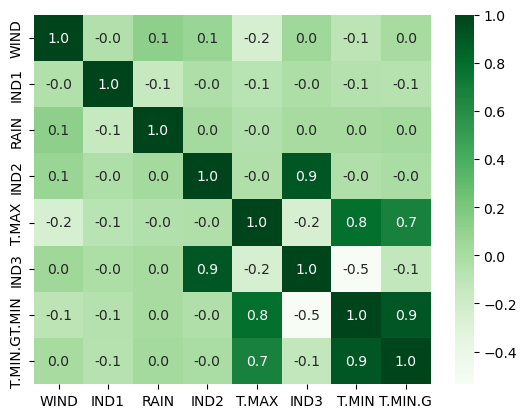

In [13]:
sns.heatmap(data.corr(), annot=True, cmap="Greens", fmt=".1f")

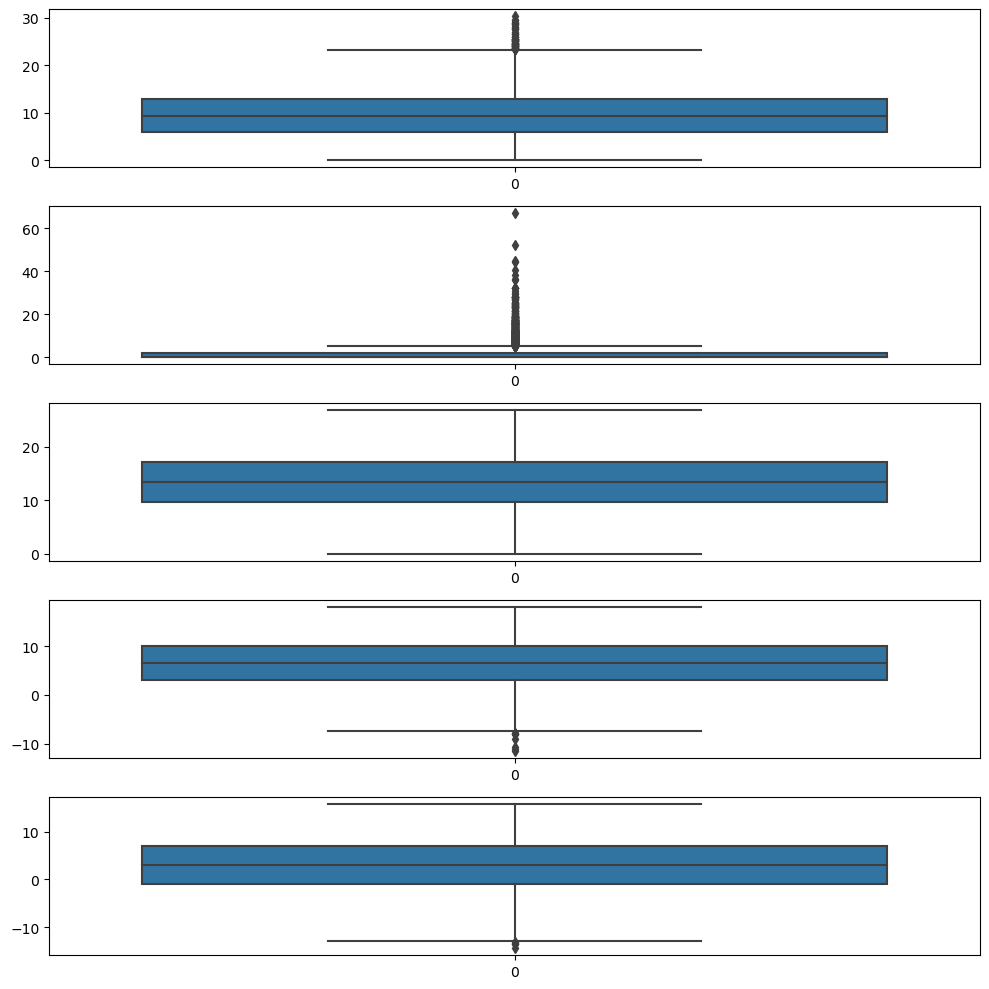

In [14]:
fig, axs = plt.subplots(5, figsize=(10, 10))
sns.boxplot(data["WIND"], ax=axs[0])
sns.boxplot(data["RAIN"], ax=axs[1])
sns.boxplot(data["T.MAX"], ax=axs[2])
sns.boxplot(data["T.MIN"], ax=axs[3])
sns.boxplot(data["T.MIN.G"], ax=axs[4])
fig.tight_layout()
plt.show()

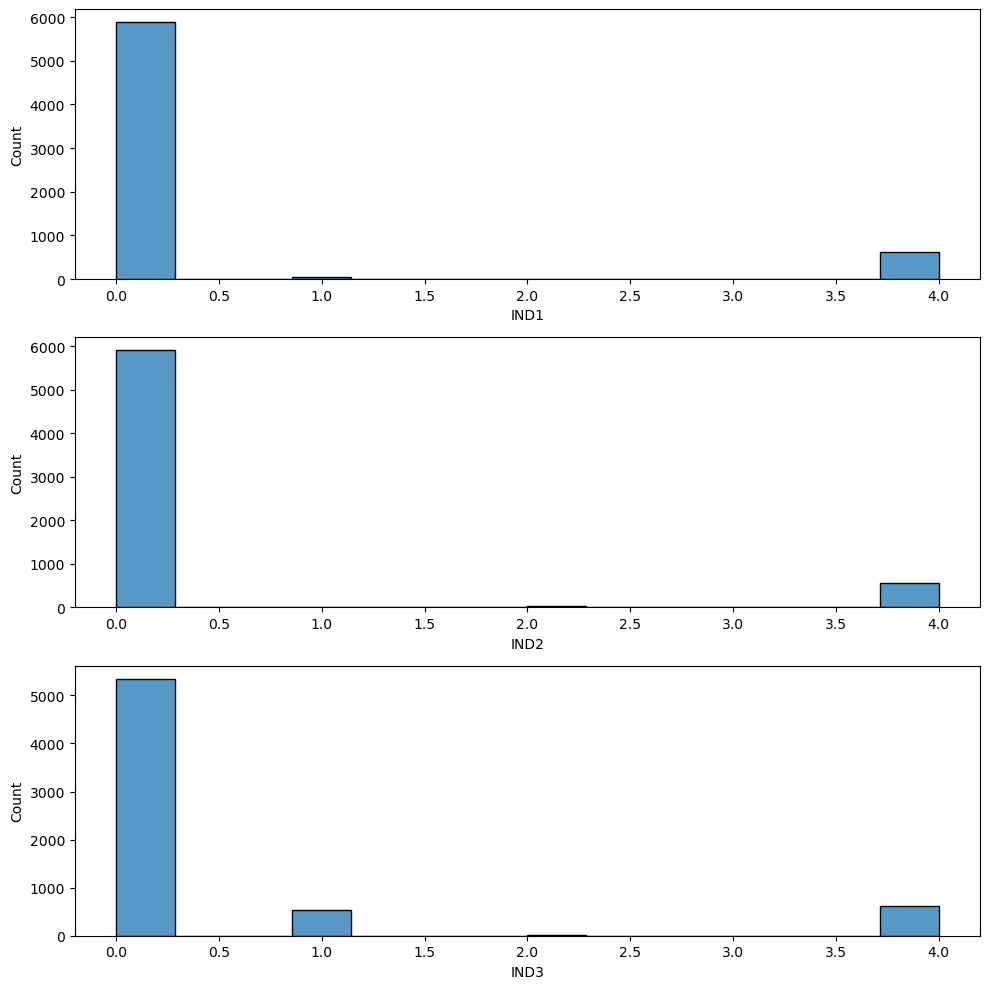

In [15]:
fig, axs = plt.subplots(3, figsize=(10, 10))
sns.histplot(data["IND1"], ax=axs[0])
sns.histplot(data["IND2"], ax=axs[1])
sns.histplot(data["IND3"], ax=axs[2])
fig.tight_layout()
plt.show()

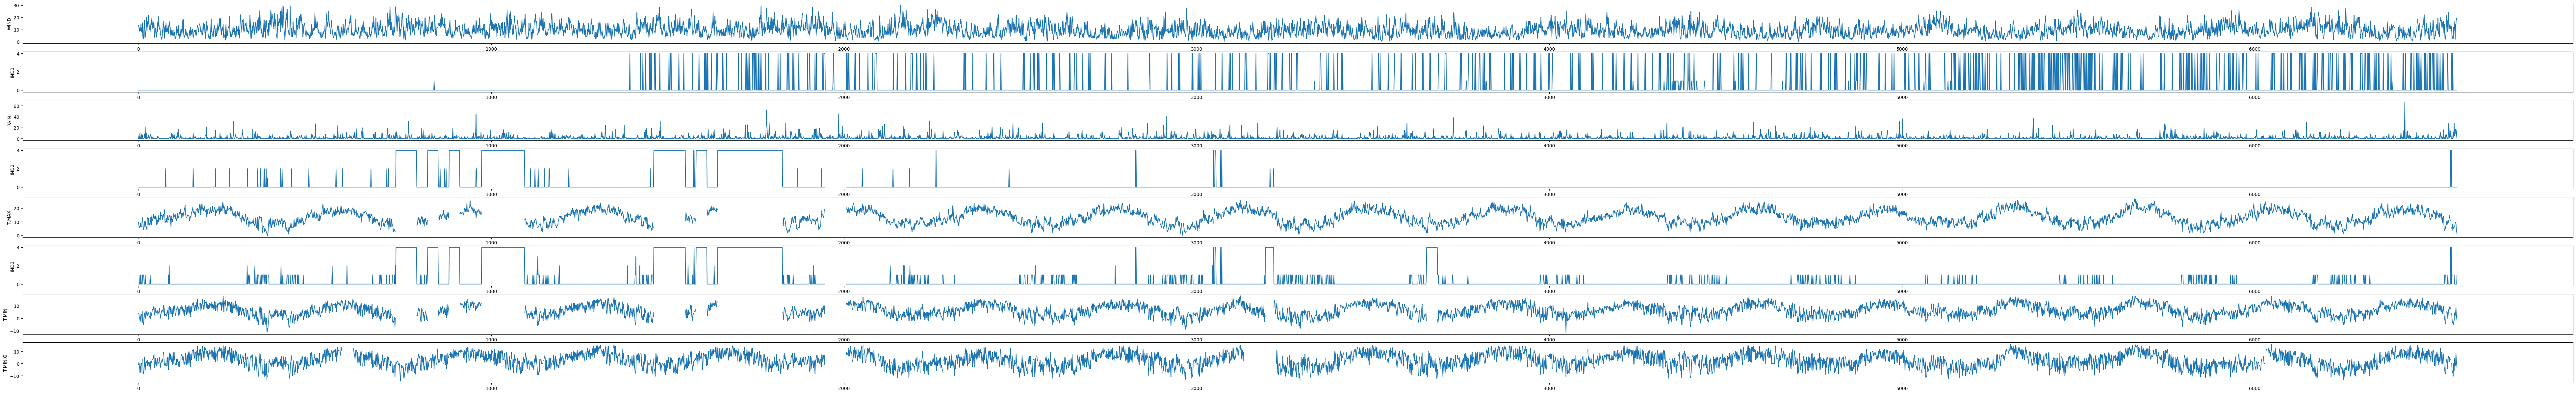

In [16]:
values = data.values

groups = [g  for g in range(8)]

i = 1

plt.figure(figsize=(100, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.ylabel(data.columns[group])
    i += 1
plt.show()

As features IND1, IND2 e IND3 parecem estar correlacionadas com as restantes features. Pelo plot das diferentes features, os valores de IND1, IND2 e IND3 são inteiros e parecem classificar a variação nos valores das features Temperature and IND (quando alguma desta features assume o valor NaN, o indicador correspondente assume o valor 4).

O autor do dataset foi questionado sobre o significado desta variáveis, para melhor entender o dataset, mas não se obteve resposta.

Estes indicadores serão desconsiderados.

In [17]:
dframe = data.drop(["IND1", "IND2", "IND3"], axis=1)

In [18]:
dframe.head()

WIND  RAIN  T.MAX  T.MIN  T.MIN.G
DATE                                          
1961-01-01  13.67   0.2    9.5    3.7     -1.0
1961-01-02  11.50   5.1    7.2    4.2      1.1
1961-01-03  11.25   0.4    5.5    0.5     -0.5
1961-01-04   8.63   0.2    5.6    0.4     -3.2
1961-01-05  11.92  10.4    7.2   -1.5     -7.5

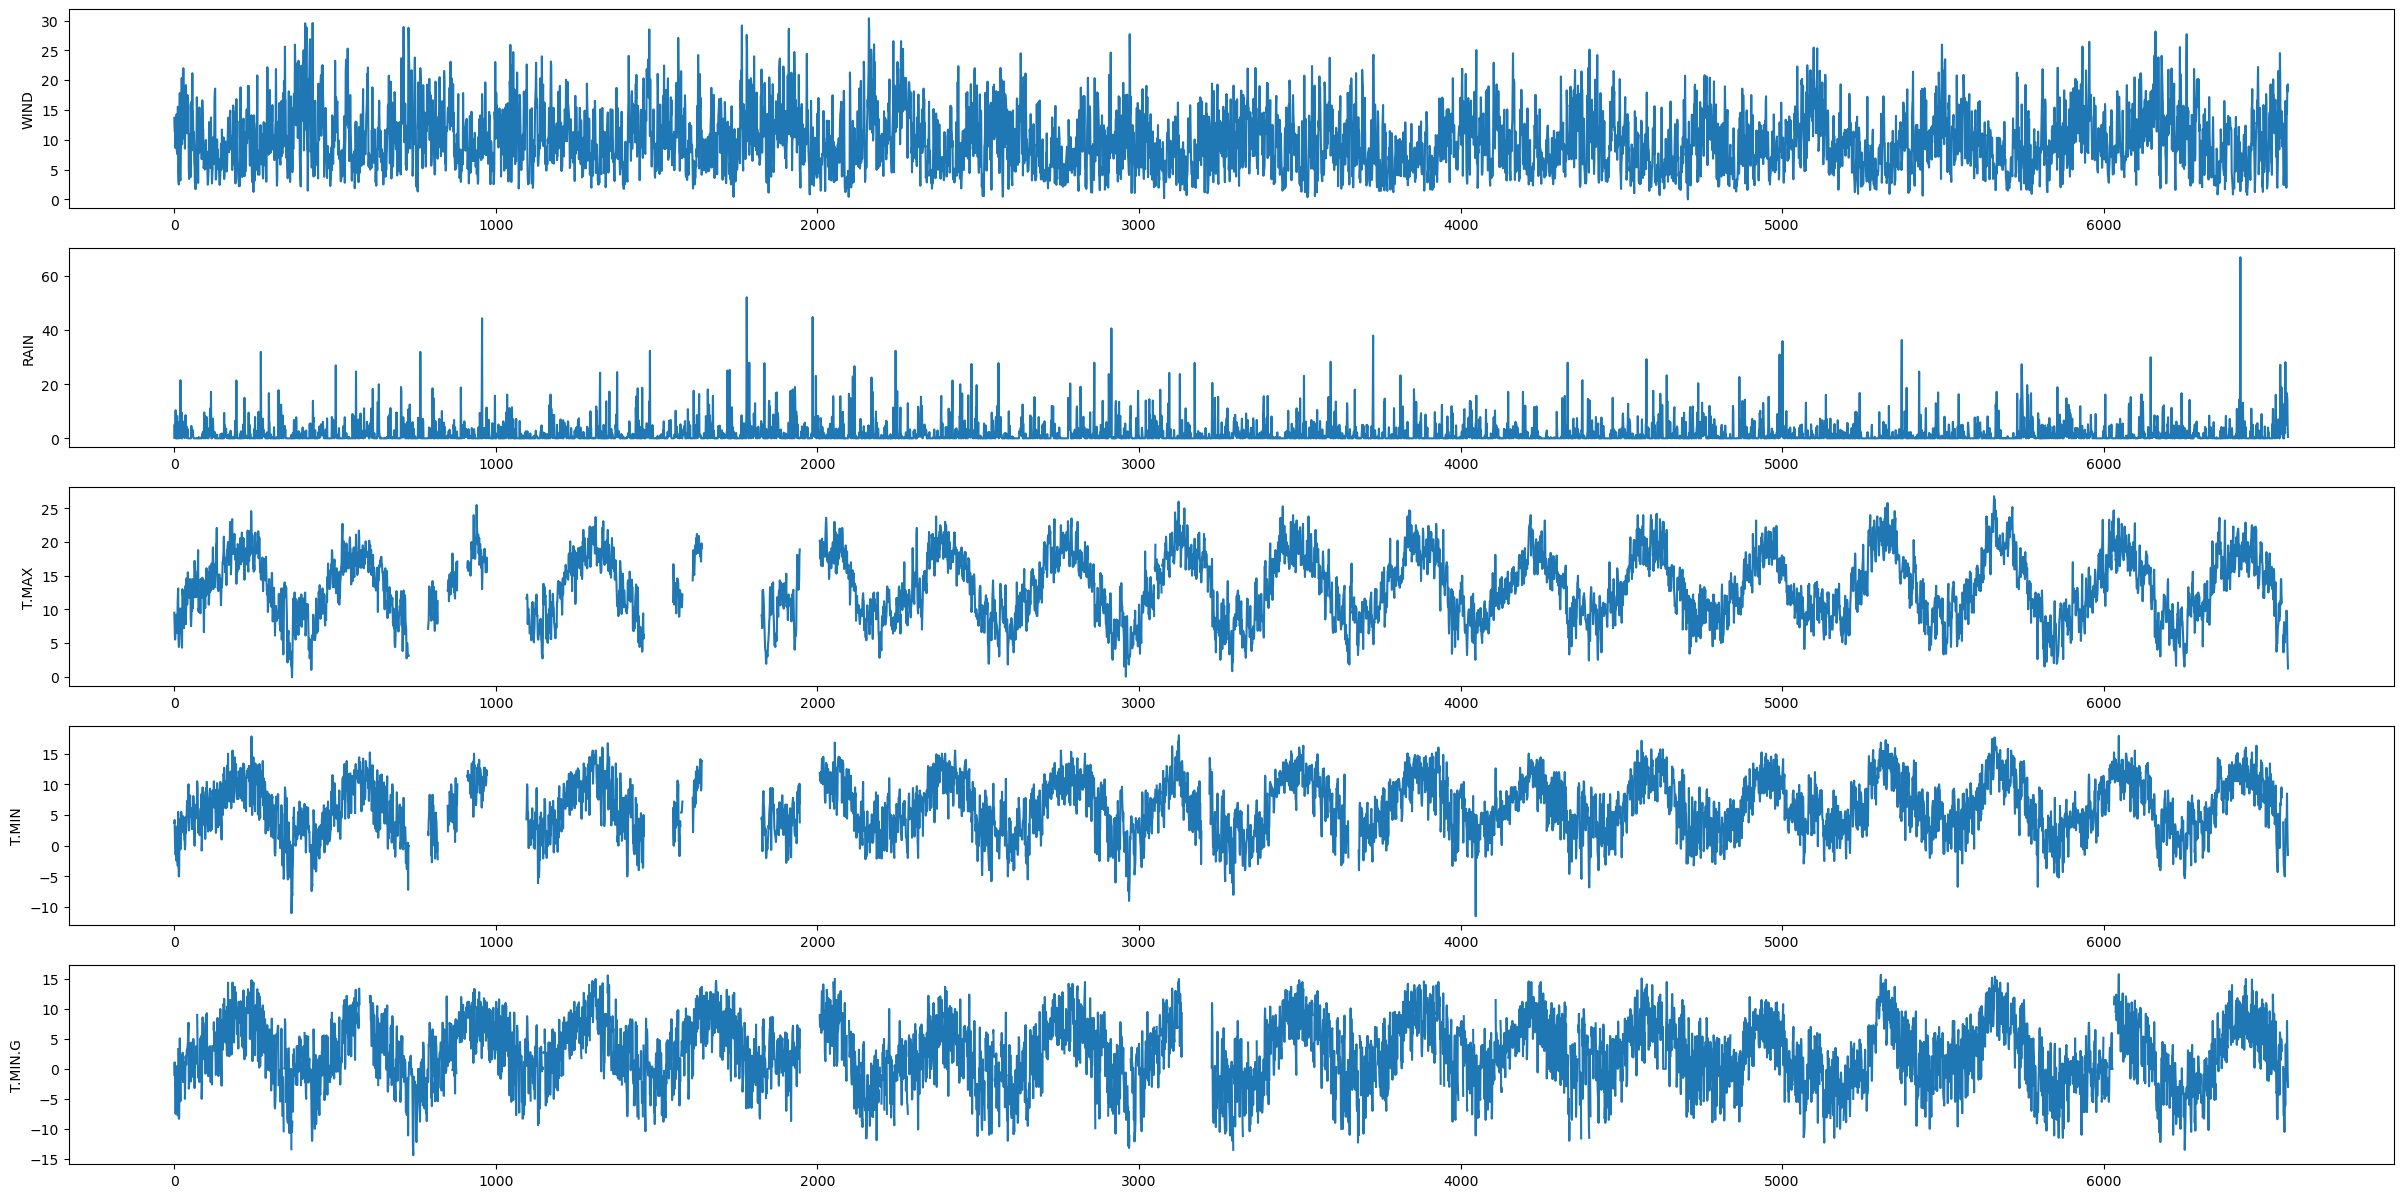

In [19]:
values = dframe.values

groups = [g  for g in range(dframe.shape[1])]

i = 1

plt.figure(figsize=(30, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.ylabel(dframe.columns[group])
    i += 1
plt.show()

### Deal with missing values

In [20]:
dframe

WIND  RAIN  T.MAX  T.MIN  T.MIN.G
DATE                                          
1961-01-01  13.67   0.2    9.5    3.7     -1.0
1961-01-02  11.50   5.1    7.2    4.2      1.1
1961-01-03  11.25   0.4    5.5    0.5     -0.5
1961-01-04   8.63   0.2    5.6    0.4     -3.2
1961-01-05  11.92  10.4    7.2   -1.5     -7.5
...           ...   ...    ...    ...      ...
1978-12-27  14.46  16.8    9.8    4.0      0.0
1978-12-28  14.33  16.0    9.1    8.5      8.0
1978-12-29  19.17  14.7    5.0    3.5      3.2
1978-12-30  18.08   4.9    2.9    0.3     -0.5
1978-12-31  19.25   0.5    1.2   -1.5     -3.0

[6574 rows x 5 columns]

In [21]:
dframe.notna().value_counts()

WIND  RAIN  T.MAX  T.MIN  T.MIN.G
True  True  True   True   True       5638
            False  False  True        543
            True   True   False       260
            False  False  False        76
            True   False  True         31
                          False        24
            False  True   True          2
dtype: int64

<AxesSubplot:>

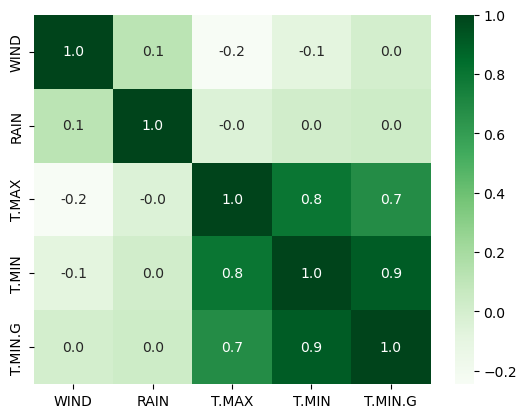

In [22]:
sns.heatmap(dframe.dropna().corr(), annot=True, cmap="Greens", fmt=".1f")

T.MAX, T.MIN e T.MIN.G são altamente correlacionadas (problema da multicolinariedade? Remover duas das três features?)

In [23]:
import miceforest as mf

In [24]:
# Create kernels. 
kernel1 = mf.ImputationKernel(
  data=dframe,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 3 iterations on each of the datasets
kernel1.mice(3,verbose=True)

Initialized logger with name mice 1-3
Dataset 0
1  | T.MIN.G | T.MAX | T.MIN
2  | T.MIN.G | T.MAX | T.MIN
3  | T.MIN.G | T.MAX | T.MIN


In [25]:
dframe = kernel1.complete_data(0)

In [26]:
# Create kernels. 
kernel2 = mf.ImputationKernel(
  data=data,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 3 iterations on each of the datasets
kernel2.mice(3,verbose=True)

data = kernel2.complete_data(0)

Initialized logger with name mice 1-3
Dataset 0
1  | IND2 | IND3 | T.MIN.G | T.MAX | T.MIN
2  | IND2 | IND3 | T.MIN.G | T.MAX | T.MIN
3  | IND2 | IND3 | T.MIN.G | T.MAX | T.MIN


In [27]:
dframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1961-01-01 to 1978-12-31
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   RAIN     6574 non-null   float64
 2   T.MAX    6574 non-null   float64
 3   T.MIN    6574 non-null   float64
 4   T.MIN.G  6574 non-null   float64
dtypes: float64(5)
memory usage: 308.2 KB


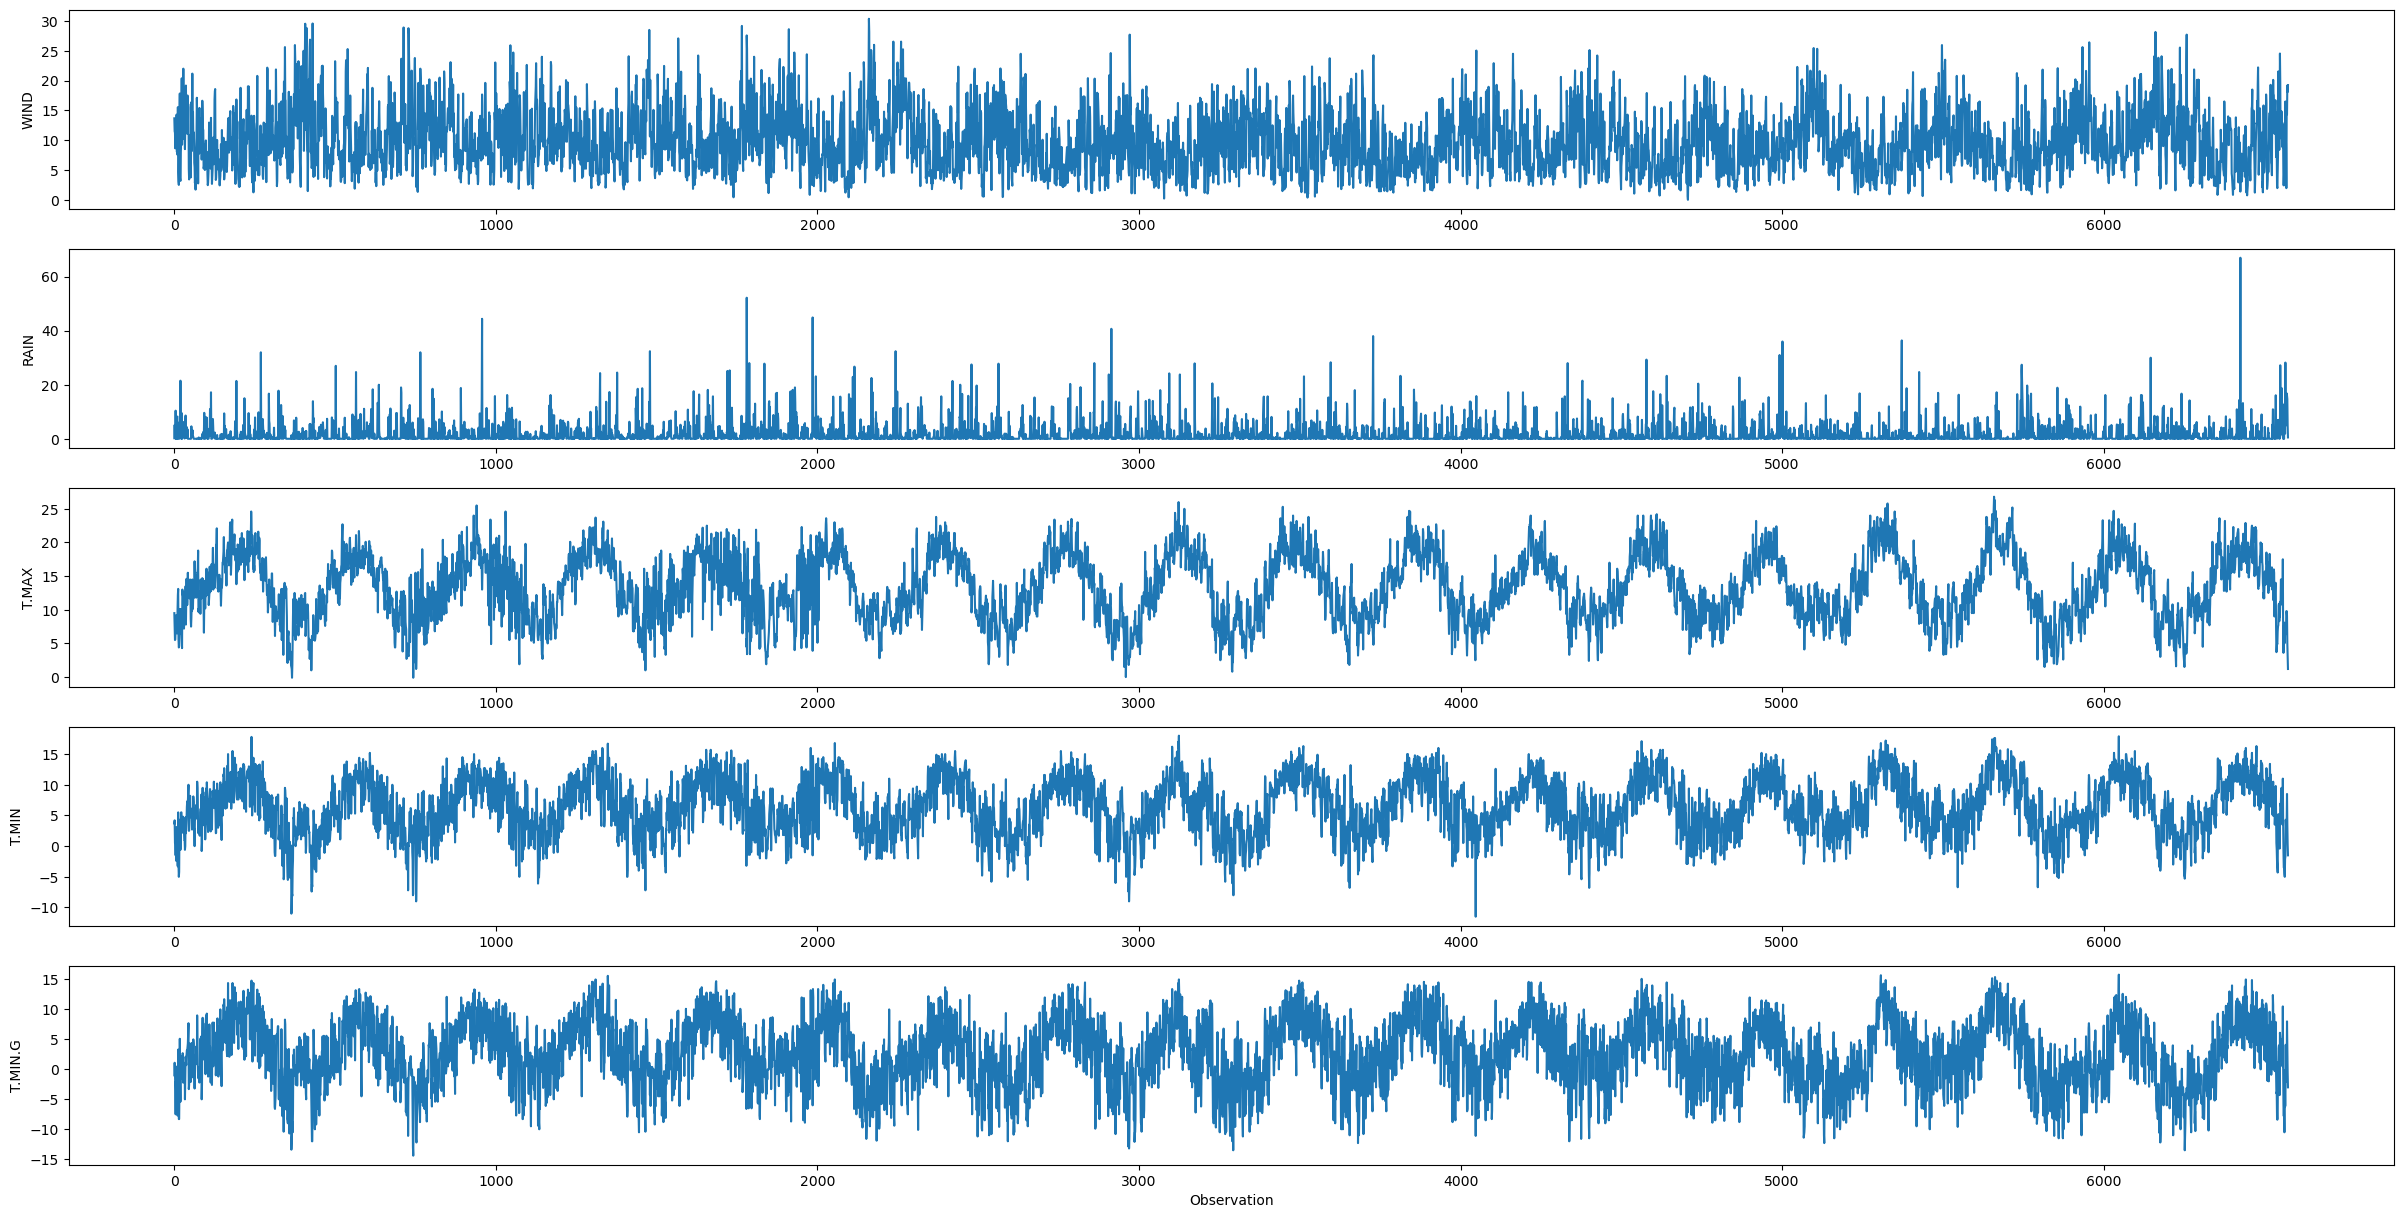

In [28]:
values = dframe.values

groups = [g  for g in range(dframe.shape[1])]

i = 1

plt.figure(figsize=(30, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.ylabel(dframe.columns[group])
    i += 1
plt.xlabel("Observation")
plt.show()

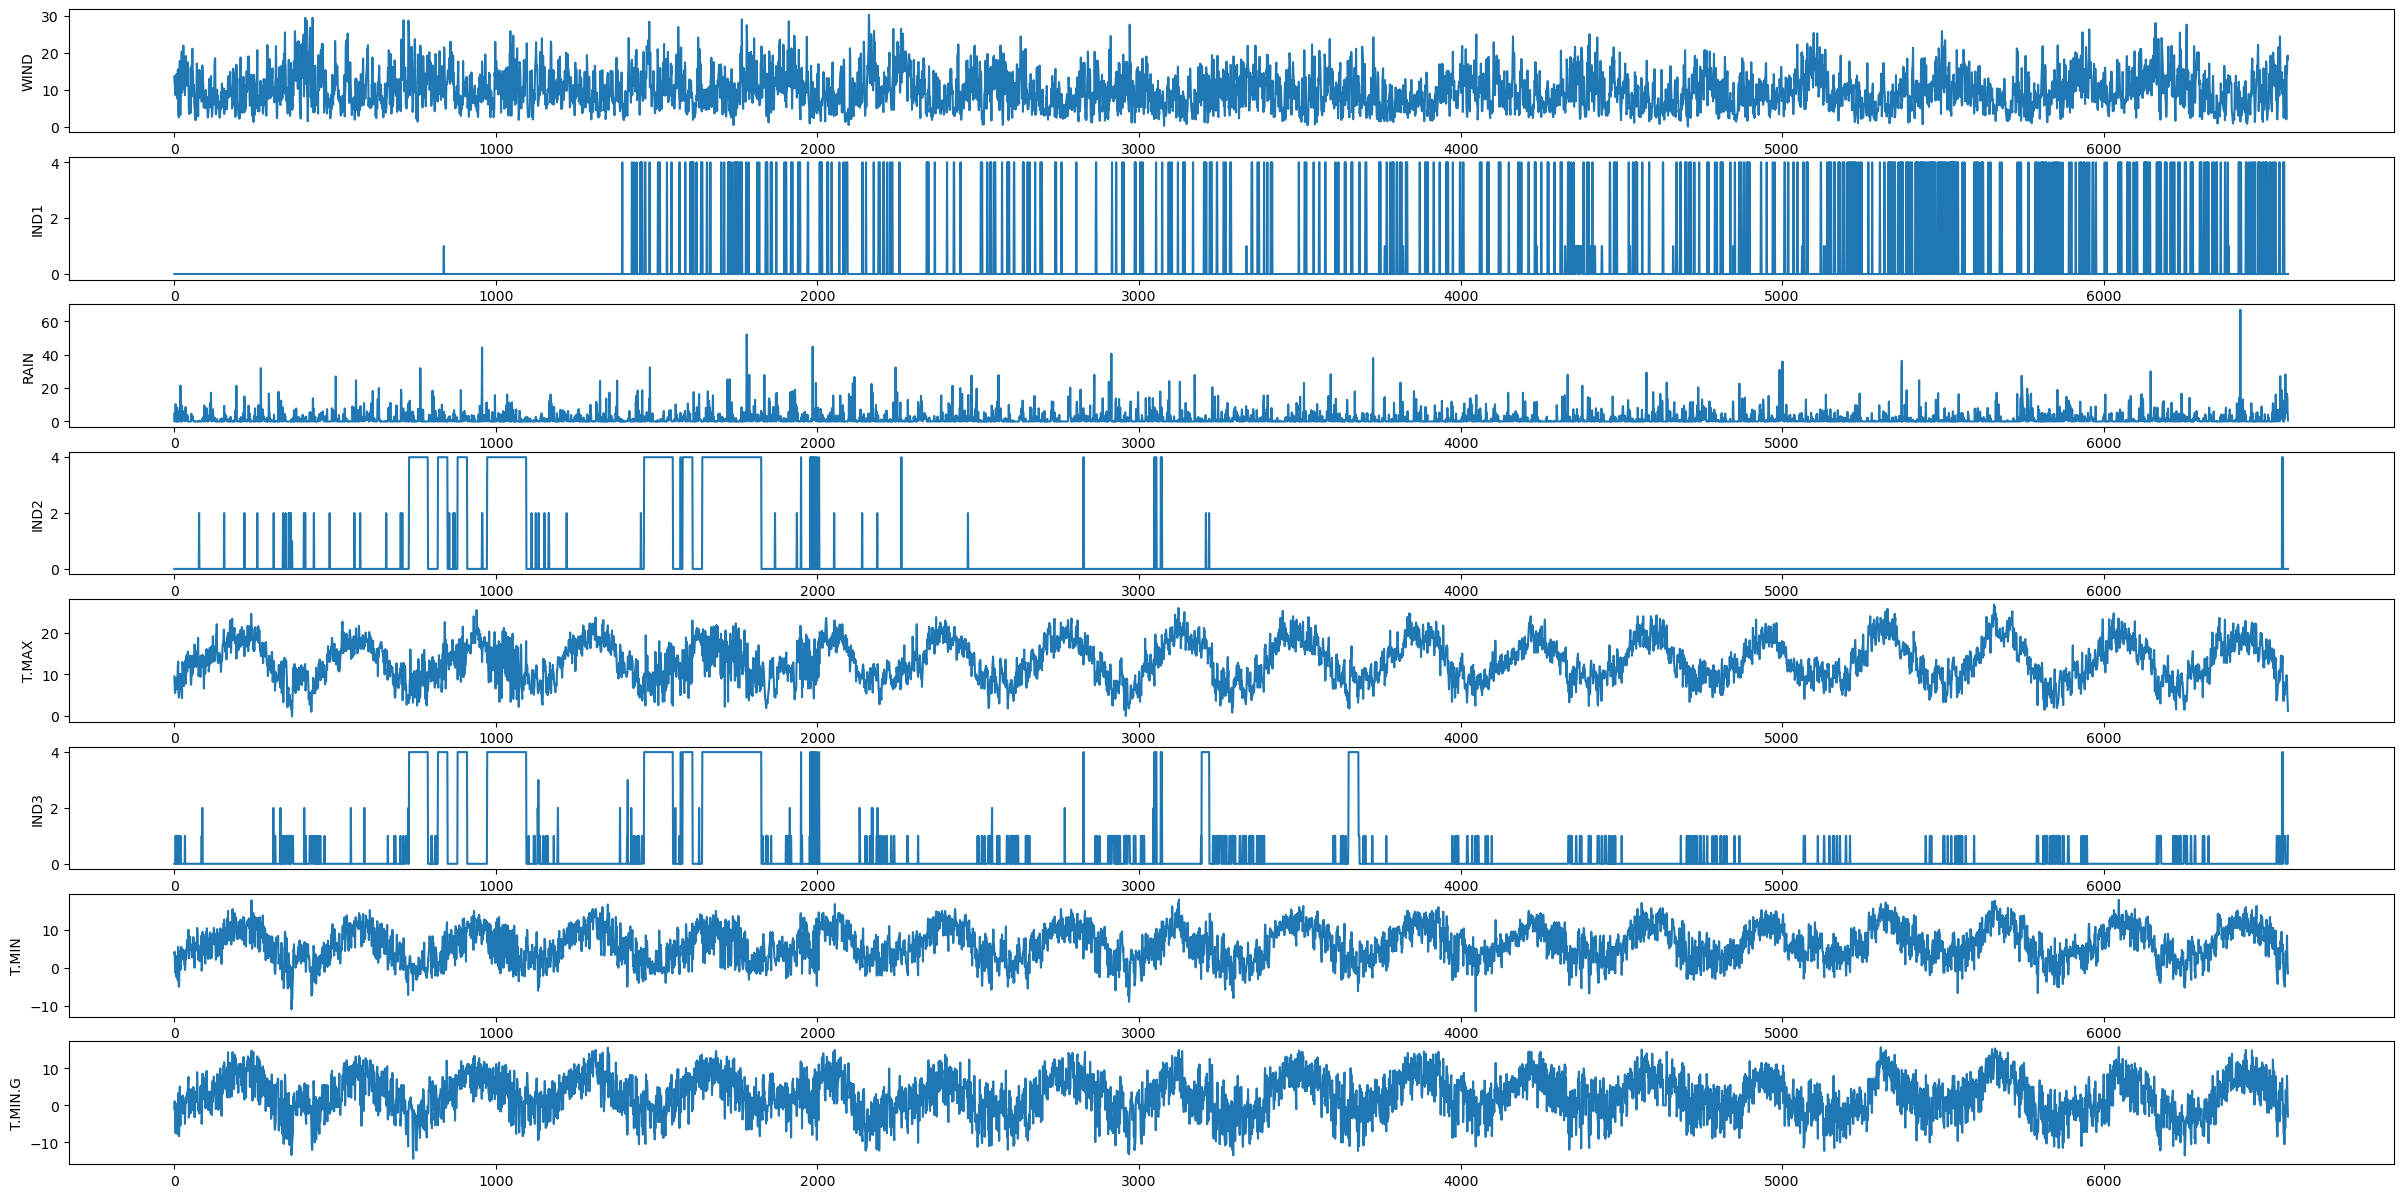

In [29]:
values = data.values

groups = [g  for g in range(data.shape[1])]

i = 1

plt.figure(figsize=(30, 15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.ylabel(data.columns[group])
    i += 1
plt.show()

In [30]:
data.head()

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                            
1961-01-01  13.67     0   0.2   0.0    9.5   0.0    3.7     -1.0
1961-01-02  11.50     0   5.1   0.0    7.2   0.0    4.2      1.1
1961-01-03  11.25     0   0.4   0.0    5.5   0.0    0.5     -0.5
1961-01-04   8.63     0   0.2   0.0    5.6   0.0    0.4     -3.2
1961-01-05  11.92     0  10.4   0.0    7.2   1.0   -1.5     -7.5

In [31]:
data.shape

(6574, 8)

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(data))
df.shape

(6574, 8)

In [65]:
df = pd.DataFrame(df, index=data.index , columns=data.columns)

In [66]:
df.head()

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                           
1961-01-01   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN
1961-01-02   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN
1961-01-03   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN
1961-01-04   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN
1961-01-05   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN

In [67]:
df['WIND_l1'] = df['WIND'].shift(1)
df['WIND_l2'] = df['WIND'].shift(2)
df['WIND_l3'] = df['WIND'].shift(3)
df['WIND_l4'] = df['WIND'].shift(4)
df['WIND_l5'] = df['WIND'].shift(5)
df['WIND_l6'] = df['WIND'].shift(6)

df.head()

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G  WIND_l1  \
DATE                                                                       
1961-01-01   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-02   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-03   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-04   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-05   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   

            WIND_l2  WIND_l3  WIND_l4  WIND_l5  WIND_l6  
DATE                                                     
1961-01-01      NaN      NaN      NaN      NaN      NaN  
1961-01-02      NaN      NaN      NaN      NaN      NaN  
1961-01-03      NaN      NaN      NaN      NaN      NaN  
1961-01-04      NaN      NaN      NaN      NaN      NaN  
1961-01-05      NaN      NaN      NaN      NaN      NaN

In [68]:
corrMatrix = df.corr()

<AxesSubplot:>

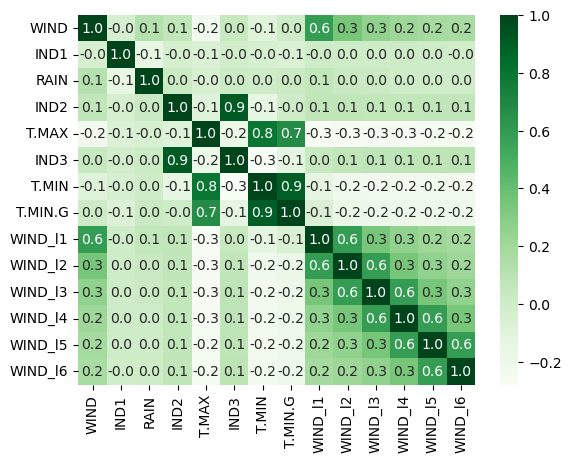

In [69]:
sns.heatmap(corrMatrix, annot=True, cmap="Greens", fmt=".1f")


In [70]:
#X_norm.drop(["IND1", "IND2", "IND3"], axis=1, inplace=True)

In [71]:
#X_norm["YEAR"] = X_norm.index.year
#df["MONTH"] = df.index.month
#df["DAY"] = df.index.day

In [72]:
df['WIND_TARGET'] = df['WIND'].shift(-1)

In [73]:
df.head()

WIND  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G  WIND_l1  \
DATE                                                                       
1961-01-01   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-02   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-03   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-04   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   
1961-01-05   NaN   NaN   NaN   NaN    NaN   NaN    NaN      NaN      NaN   

            WIND_l2  WIND_l3  WIND_l4  WIND_l5  WIND_l6  WIND_TARGET  
DATE                                                                  
1961-01-01      NaN      NaN      NaN      NaN      NaN          NaN  
1961-01-02      NaN      NaN      NaN      NaN      NaN          NaN  
1961-01-03      NaN      NaN      NaN      NaN      NaN          NaN  
1961-01-04      NaN      NaN      NaN      NaN      NaN          NaN  
1961-01-05      NaN      NaN      NaN      NaN      NaN          NaN

In [74]:
df.dropna(inplace=True)
df

WIND  IND1      RAIN  IND2     T.MAX  IND3     T.MIN  \
DATE                                                                   
1961-01-19  0.122160   0.0  0.013433   0.0  0.249071  0.00  0.444068   
1961-01-20  0.104379   0.0  0.320896   0.0  0.349442  0.25  0.369492   
1961-01-21  0.264735   0.0  0.002985   0.0  0.379182  0.00  0.444068   
1961-01-22  0.308857   0.0  0.004478   0.0  0.245353  0.00  0.576271   
1961-01-23  0.451103   0.0  0.000000   0.0  0.245353  0.00  0.576271   
...              ...   ...       ...   ...       ...   ...       ...   
1978-12-24  0.403359   0.0  0.073134   0.0  0.245353  0.00  0.535593   
1978-12-25  0.286796   0.0  0.126866   0.0  0.282528  0.00  0.501695   
1978-12-26  0.064537   0.0  0.134328   0.0  0.368030  0.00  0.467797   
1978-12-27  0.476128   0.0  0.250746   0.0  0.368030  0.00  0.525424   
1978-12-28  0.471847   0.0  0.238806   0.0  0.342007  0.00  0.677966   

             T.MIN.G   WIND_l1   WIND_l2   WIND_l3   WIND_l4   WIND_l5  \
DATE                                                                     
1961-01-19  0.410596  0.587093  0.441883  0.304577  0.082318  0.101416   
1961-01-20  0.298013  0.122160  0.587093  0.441883  0.304577  0.082318   
1961-01-21  0.490066  0.104379  0.122160  0.587093  0.441883  0.304577   
1961-01-22  0.519868  0.264735  0.104379  0.122160  0.587093  0.441883   
1961-01-23  0.549669  0.308857  0.264735  0.104379  0.122160  0.587093   
...              ...       ...       ...       ...       ...       ...   
1978-12-24  0.612583  0.543299  0.081001  0.384261  0.149490  0.156404   
1978-12-25  0.470199  0.403359  0.543299  0.081001  0.384261  0.149490   
1978-12-26  0.410596  0.286796  0.403359  0.543299  0.081001  0.384261   
1978-12-27  0.476821  0.064537  0.286796  0.403359  0.543299  0.081001   
1978-12-28  0.741722  0.476128  0.064537  0.286796  0.403359  0.543299   

             WIND_l6  WIND_TARGET  
DATE                               
1961-01-19  0.152453     0.104379  
1961-01-20  0.101416     0.264735  
1961-01-21  0.082318     0.308857  
1961-01-22  0.304577     0.451103  
1961-01-23  0.441883     0.671057  
...              ...          ...  
1978-12-24  0.079684     0.286796  
1978-12-25  0.156404     0.064537  
1978-12-26  0.149490     0.476128  
1978-12-27  0.384261     0.471847  
1978-12-28  0.081001     0.631215  

[6553 rows x 15 columns]

In [75]:
df.columns

Index(['WIND', 'IND1', 'RAIN', 'IND2', 'T.MAX', 'IND3', 'T.MIN', 'T.MIN.G',
       'WIND_l1', 'WIND_l2', 'WIND_l3', 'WIND_l4', 'WIND_l5', 'WIND_l6',
       'WIND_TARGET'],
      dtype='object')

In [76]:
df = df.reindex(['IND1', 'IND2', 'IND3', 
                'RAIN', 'T.MAX', 'T.MIN', 'T.MIN.G',
                'WIND_l6', 'WIND_l5', 'WIND_l4', 'WIND_l3', 'WIND_l2', 'WIND_l1', 'WIND', 
                'WIND_TARGET'], axis=1)
df

IND1  IND2  IND3      RAIN     T.MAX     T.MIN   T.MIN.G  \
DATE                                                                   
1961-01-19   0.0   0.0  0.00  0.013433  0.249071  0.444068  0.410596   
1961-01-20   0.0   0.0  0.25  0.320896  0.349442  0.369492  0.298013   
1961-01-21   0.0   0.0  0.00  0.002985  0.379182  0.444068  0.490066   
1961-01-22   0.0   0.0  0.00  0.004478  0.245353  0.576271  0.519868   
1961-01-23   0.0   0.0  0.00  0.000000  0.245353  0.576271  0.549669   
...          ...   ...   ...       ...       ...       ...       ...   
1978-12-24   0.0   0.0  0.00  0.073134  0.245353  0.535593  0.612583   
1978-12-25   0.0   0.0  0.00  0.126866  0.282528  0.501695  0.470199   
1978-12-26   0.0   0.0  0.00  0.134328  0.368030  0.467797  0.410596   
1978-12-27   0.0   0.0  0.00  0.250746  0.368030  0.525424  0.476821   
1978-12-28   0.0   0.0  0.00  0.238806  0.342007  0.677966  0.741722   

             WIND_l6   WIND_l5   WIND_l4   WIND_l3   WIND_l2   WIND_l1  \
DATE                                                                     
1961-01-19  0.152453  0.101416  0.082318  0.304577  0.441883  0.587093   
1961-01-20  0.101416  0.082318  0.304577  0.441883  0.587093  0.122160   
1961-01-21  0.082318  0.304577  0.441883  0.587093  0.122160  0.104379   
1961-01-22  0.304577  0.441883  0.587093  0.122160  0.104379  0.264735   
1961-01-23  0.441883  0.587093  0.122160  0.104379  0.264735  0.308857   
...              ...       ...       ...       ...       ...       ...   
1978-12-24  0.079684  0.156404  0.149490  0.384261  0.081001  0.543299   
1978-12-25  0.156404  0.149490  0.384261  0.081001  0.543299  0.403359   
1978-12-26  0.149490  0.384261  0.081001  0.543299  0.403359  0.286796   
1978-12-27  0.384261  0.081001  0.543299  0.403359  0.286796  0.064537   
1978-12-28  0.081001  0.543299  0.403359  0.286796  0.064537  0.476128   

                WIND  WIND_TARGET  
DATE                               
1961-01-19  0.122160     0.104379  
1961-01-20  0.104379     0.264735  
1961-01-21  0.264735     0.308857  
1961-01-22  0.308857     0.451103  
1961-01-23  0.451103     0.671057  
...              ...          ...  
1978-12-24  0.403359     0.286796  
1978-12-25  0.286796     0.064537  
1978-12-26  0.064537     0.476128  
1978-12-27  0.476128     0.471847  
1978-12-28  0.471847     0.631215  

[6553 rows x 15 columns]

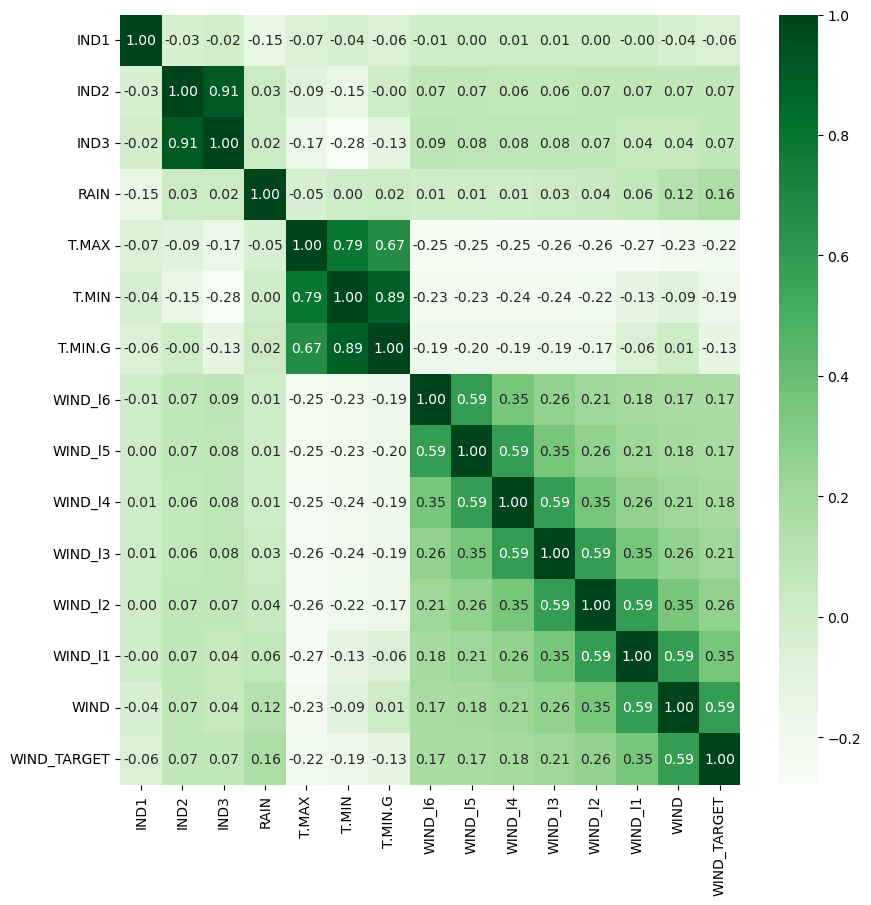

In [77]:
corrMatrix = df.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, cmap="Greens", fmt=".2f")
plt.show()

In [78]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

### Train/Test split

In [79]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25,random_state=0, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0, shuffle=False)

In [80]:
X_train.tail()

IND1  IND2  IND3      RAIN     T.MAX     T.MIN   T.MIN.G  \
DATE                                                                   
1974-06-29   0.0   0.0   0.0  0.013433  0.628253  0.681356  0.615894   
1974-06-30   0.0   0.0   0.0  0.047761  0.724907  0.681356  0.596026   
1974-07-01   0.0   0.0   0.0  0.028358  0.706320  0.752542  0.721854   
1974-07-02   0.0   0.0   0.0  0.138806  0.513011  0.677966  0.596026   
1974-07-03   0.0   0.0   0.0  0.126866  0.654275  0.633898  0.602649   

             WIND_l6   WIND_l5   WIND_l4   WIND_l3   WIND_l2   WIND_l1  \
DATE                                                                     
1974-06-29  0.279881  0.226210  0.277247  0.374712  0.338821  0.137307   
1974-06-30  0.226210  0.277247  0.374712  0.338821  0.137307  0.104379   
1974-07-01  0.277247  0.374712  0.338821  0.137307  0.104379  0.172868   
1974-07-02  0.374712  0.338821  0.137307  0.104379  0.172868  0.426737   
1974-07-03  0.338821  0.137307  0.104379  0.172868  0.426737  0.249588   

                WIND  
DATE                  
1974-06-29  0.104379  
1974-06-30  0.172868  
1974-07-01  0.426737  
1974-07-02  0.249588  
1974-07-03  0.366151

In [81]:
X_test.head()

IND1  IND2  IND3      RAIN     T.MAX     T.MIN   T.MIN.G  \
DATE                                                                   
1974-07-04   0.0   0.0   0.0  0.152239  0.635688  0.783051  0.771523   
1974-07-05   0.0   0.0   0.0  0.001493  0.676580  0.837288  0.807947   
1974-07-06   1.0   0.0   0.0  0.000000  0.695167  0.677966  0.639073   
1974-07-07   1.0   0.0   0.0  0.000000  0.773234  0.881356  0.834437   
1974-07-08   0.0   0.0   0.0  0.004478  0.773234  0.905085  0.857616   

             WIND_l6   WIND_l5   WIND_l4   WIND_l3   WIND_l2   WIND_l1  \
DATE                                                                     
1974-07-04  0.137307  0.104379  0.172868  0.426737  0.249588  0.366151   
1974-07-05  0.104379  0.172868  0.426737  0.249588  0.366151  0.270333   
1974-07-06  0.172868  0.426737  0.249588  0.366151  0.270333  0.408956   
1974-07-07  0.426737  0.249588  0.366151  0.270333  0.408956  0.243991   
1974-07-08  0.249588  0.366151  0.270333  0.408956  0.243991  0.230491   

                WIND  
DATE                  
1974-07-04  0.270333  
1974-07-05  0.408956  
1974-07-06  0.243991  
1974-07-07  0.230491  
1974-07-08  0.262101

## Model and hyper parameter selection
1.	Train model to check "original" performance with default parameters
2.  Optimize parameters theta (to minimize some cost function) using the training set for all models. Compute some performance metrics with training data. (In cross-validation)
3.	Get the best model from the cross-validation from step 2 (Retrain the best model from step 2 in cross validation from the parameters got at step 2). 
4.  Compute test data performance metric (the real model performance)

In [82]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn import metrics

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_train)

print('MAE:', metrics.mean_absolute_error(y_train, lin_pred))
print('MSE:', metrics.mean_squared_error(y_train, lin_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, lin_pred)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, lin_pred))
print('R2:', metrics.r2_score(y_train, lin_pred))

MAE: 0.10402246968659531
MSE: 0.017092923027250226
RMSE: 0.13073990602432842
MAPE: 172554095139.1982
R2: 0.37335884854441026


In [100]:
from sklearn.model_selection import cross_val_score, cross_val_predict

#Next we do cross validation, which splits apart our training data and fits the model on different samples and 
# gives scores for each sample to get the best fit model before we test it on the testing data.

scores = cross_val_score(lin_reg, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error')    #cv is the number of folds, scores will give an array of scores

print('scores: {}, mean: {}, std: {}'.format(scores, np.mean(scores), np.std(scores)))

#To get predictions (y_hat) and check them all in one using cross validation

predictions = cross_val_predict(lin_reg, X_test, y_test, cv = 5)     #y_test is needed here in predictions to get scores for each fold of cv

accuracy = metrics.r2_score(y_test, predictions)  #this says the accuracy of the predictions from the best cv fold


#If this is good, continue to fit the model on the data


lin_reg.fit(X_train, y_train)

y_hat = lin_reg.predict(X_test)      #this gives me my predictions

lin_reg.score(X_test, y_test)     #this tells me my model performance

scores: [-0.10754763 -0.10965376 -0.10566738 -0.10132363 -0.0980169 ], mean: -0.10444186019874983, std: 0.004226465115854883


0.3970003905246201

In [101]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, predictions))
print('R2:', metrics.r2_score(y_test, predictions))

MAE: 0.09788063966194639
MSE: 0.015465263540084343
RMSE: 0.12435941275224945
MAPE: 0.4556993796836286
R2: 0.3961361403288458


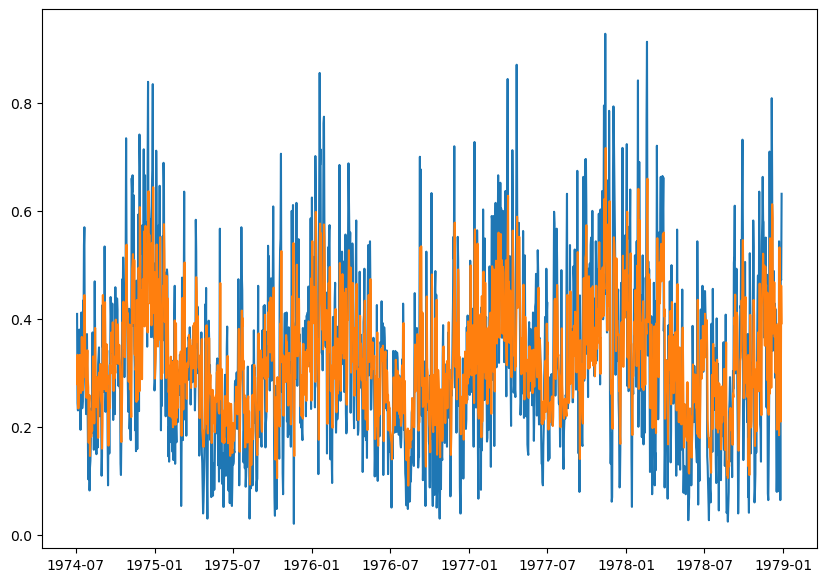

In [111]:
predictions = pd.Series(predictions, index=y_test.index)


plt.figure(figsize=(10,7))
plt.plot(y_test)
plt.plot(predictions)
plt.show()

In [102]:
print('MAE:', metrics.mean_absolute_error(y_test, y_hat))
print('MSE:', metrics.mean_squared_error(y_test, y_hat))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_hat)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_hat))
print('R2:', metrics.r2_score(y_test, y_hat))

MAE: 0.09786992922306435
MSE: 0.01544312964876404
RMSE: 0.12427038926777384
MAPE: 0.4507358207826859
R2: 0.3970003905246201


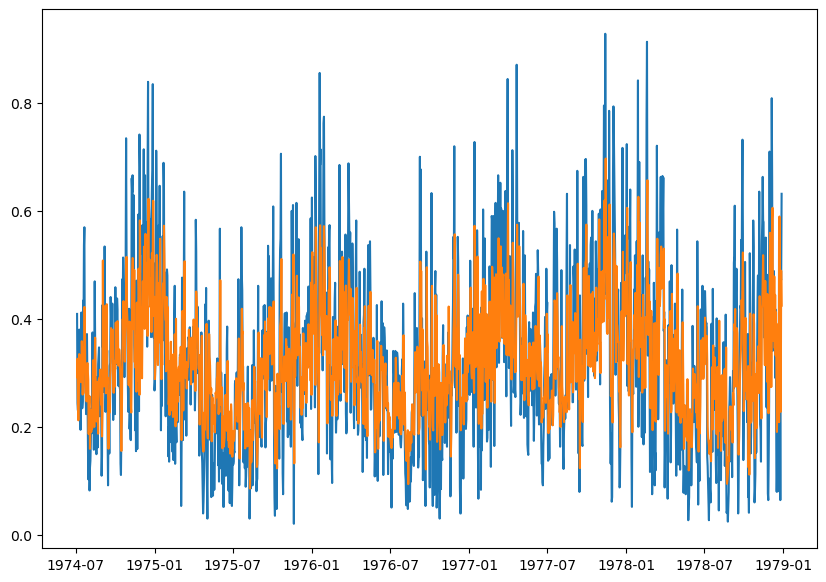

In [104]:
y_hat = pd.Series(y_hat, index=y_test.index)
y_hat

plt.figure(figsize=(10,7))
plt.plot(y_test)
plt.plot(y_hat)
plt.show()

In [105]:
df_y_hat= X_test[['IND1', 'RAIN', 'IND2', 'T.MAX', 'IND3', 'T.MIN', 'T.MIN.G']]
df_y_hat['WIND'] = y_hat
df_y_hat

C:\Users\Adriano\AppData\Local\Temp\ipykernel_12936\1801876674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_hat['WIND'] = y_hat


IND1      RAIN  IND2     T.MAX  IND3     T.MIN   T.MIN.G      WIND
DATE                                                                          
1974-07-04   0.0  0.152239   0.0  0.635688   0.0  0.783051  0.771523  0.291887
1974-07-05   0.0  0.001493   0.0  0.676580   0.0  0.837288  0.807947  0.326026
1974-07-06   1.0  0.000000   0.0  0.695167   0.0  0.677966  0.639073  0.240542
1974-07-07   1.0  0.000000   0.0  0.773234   0.0  0.881356  0.834437  0.212153
1974-07-08   0.0  0.004478   0.0  0.773234   0.0  0.905085  0.857616  0.242574
...          ...       ...   ...       ...   ...       ...       ...       ...
1978-12-24   0.0  0.073134   0.0  0.245353   0.0  0.535593  0.612583  0.353194
1978-12-25   0.0  0.126866   0.0  0.282528   0.0  0.501695  0.470199  0.332491
1978-12-26   0.0  0.134328   0.0  0.368030   0.0  0.467797  0.410596  0.227918
1978-12-27   0.0  0.250746   0.0  0.368030   0.0  0.525424  0.476821  0.488915
1978-12-28   0.0  0.238806   0.0  0.342007   0.0  0.677966  0.741722  0.424203

[1639 rows x 8 columns]

In [106]:
# shift column 'Name' to first position
first_column = df_y_hat.pop('WIND')
  
# insert column using insert(position,column_name,
# first_column) function
df_y_hat.insert(0, 'WIND', first_column)
df_y_hat

WIND  IND1      RAIN  IND2     T.MAX  IND3     T.MIN   T.MIN.G
DATE                                                                          
1974-07-04  0.291887   0.0  0.152239   0.0  0.635688   0.0  0.783051  0.771523
1974-07-05  0.326026   0.0  0.001493   0.0  0.676580   0.0  0.837288  0.807947
1974-07-06  0.240542   1.0  0.000000   0.0  0.695167   0.0  0.677966  0.639073
1974-07-07  0.212153   1.0  0.000000   0.0  0.773234   0.0  0.881356  0.834437
1974-07-08  0.242574   0.0  0.004478   0.0  0.773234   0.0  0.905085  0.857616
...              ...   ...       ...   ...       ...   ...       ...       ...
1978-12-24  0.353194   0.0  0.073134   0.0  0.245353   0.0  0.535593  0.612583
1978-12-25  0.332491   0.0  0.126866   0.0  0.282528   0.0  0.501695  0.470199
1978-12-26  0.227918   0.0  0.134328   0.0  0.368030   0.0  0.467797  0.410596
1978-12-27  0.488915   0.0  0.250746   0.0  0.368030   0.0  0.525424  0.476821
1978-12-28  0.424203   0.0  0.238806   0.0  0.342007   0.0  0.677966  0.741722

[1639 rows x 8 columns]

In [107]:
rescled_data_hat = pd.DataFrame(scaler.inverse_transform(df_y_hat), index=X_test.index, columns=['WIND_PREDICTIONS', 'IND1', 'RAIN', 'IND2', 'T.MAX', 'IND3', 'T.MIN', 'T.MIN.G'])
rescled_data_hat

WIND_PREDICTIONS  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                                       
1974-07-04          8.864609   0.0  10.2   0.0   17.0   0.0   11.6      8.9
1974-07-05          9.901423   0.0   0.1   0.0   18.1   0.0   13.2     10.0
1974-07-06          7.305266   4.0   0.0   0.0   18.6   0.0    8.5      4.9
1974-07-07          6.443093   4.0   0.0   0.0   20.7   0.0   14.5     10.8
1974-07-08          7.366973   0.0   0.3   0.0   20.7   0.0   15.2     11.5
...                      ...   ...   ...   ...    ...   ...    ...      ...
1978-12-24         10.726498   0.0   4.9   0.0    6.5   0.0    4.3      4.1
1978-12-25         10.097741   0.0   8.5   0.0    7.5   0.0    3.3     -0.2
1978-12-26          6.921855   0.0   9.0   0.0    9.8   0.0    2.3     -2.0
1978-12-27         14.848343   0.0  16.8   0.0    9.8   0.0    4.0      0.0
1978-12-28         12.883045   0.0  16.0   0.0    9.1   0.0    8.5      8.0

[1639 rows x 8 columns]

In [108]:
df_y_test= X_test[['IND1', 'RAIN', 'IND2', 'T.MAX', 'IND3', 'T.MIN', 'T.MIN.G']]
df_y_test['WIND'] = y_test
df_y_test

# shift column 'Name' to first position
first_column = df_y_test.pop('WIND')
# insert column using insert(position,column_name,
# first_column) function
df_y_test.insert(0, 'WIND', first_column)
df_y_test

rescled_data_test = pd.DataFrame(scaler.inverse_transform(df_y_test), index=X_test.index, columns=['WIND_PRED', 'IND1', 'RAIN', 'IND2', 'T.MAX', 'IND3', 'T.MIN', 'T.MIN.G'])
rescled_data_test

C:\Users\Adriano\AppData\Local\Temp\ipykernel_12936\159364152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_test['WIND'] = y_test


WIND_PRED  IND1  RAIN  IND2  T.MAX  IND3  T.MIN  T.MIN.G
DATE                                                                
1974-07-04      12.42   0.0  10.2   0.0   17.0   0.0   11.6      8.9
1974-07-05       7.41   0.0   0.1   0.0   18.1   0.0   13.2     10.0
1974-07-06       7.00   4.0   0.0   0.0   18.6   0.0    8.5      4.9
1974-07-07       7.96   4.0   0.0   0.0   20.7   0.0   14.5     10.8
1974-07-08      10.41   0.0   0.3   0.0   20.7   0.0   15.2     11.5
...               ...   ...   ...   ...    ...   ...    ...      ...
1978-12-24       8.71   0.0   4.9   0.0    6.5   0.0    4.3      4.1
1978-12-25       1.96   0.0   8.5   0.0    7.5   0.0    3.3     -0.2
1978-12-26      14.46   0.0   9.0   0.0    9.8   0.0    2.3     -2.0
1978-12-27      14.33   0.0  16.8   0.0    9.8   0.0    4.0      0.0
1978-12-28      19.17   0.0  16.0   0.0    9.1   0.0    8.5      8.0

[1639 rows x 8 columns]

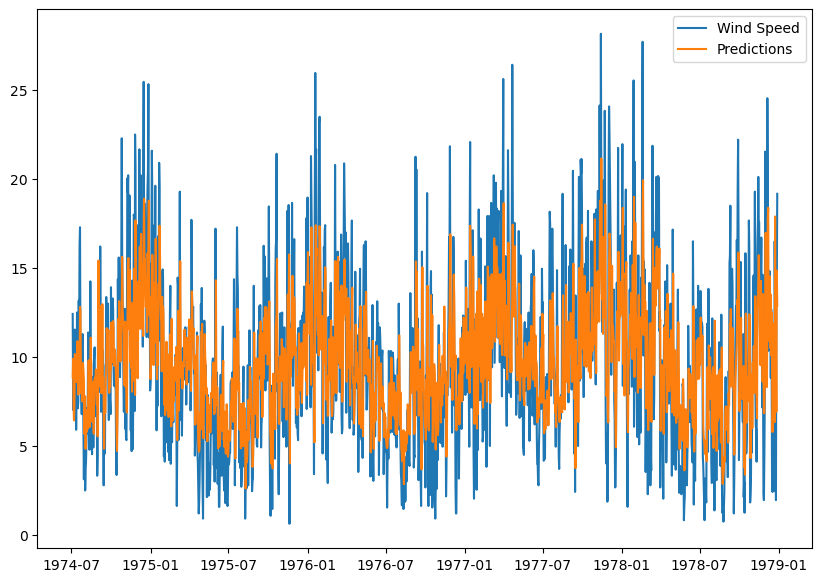

In [109]:
plt.figure(figsize=(10,7))
plt.plot(rescled_data_test['WIND_PRED'])
plt.plot(rescled_data_hat['WIND_PREDICTIONS'])
plt.legend(['Wind Speed', 'Predictions'])
plt.show()

In [110]:
y = rescled_data_test['WIND_PRED']
y_hat = rescled_data_hat['WIND_PREDICTIONS']


print('MAE:', metrics.mean_absolute_error(y, y_hat))
print('MSE:', metrics.mean_squared_error(y, y_hat))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_hat)))
print('MAPE:', metrics.mean_absolute_percentage_error(y, y_hat))
print('R2:', metrics.r2_score(y, y_hat))

MAE: 2.9723097505044644
MSE: 14.243768326539112
RMSE: 3.774091722062291
MAPE: 0.4507358207826859
R2: 0.3970003905246202


In [112]:
# Stocastic Gradient Descent Regression

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(loss = 'squared_error', learning_rate = 'constant', eta0 = 0.01, penalty = 'None')
sgd_reg.fit(X_train, y_train)
sgd_pred = sgd_reg.predict(X_train)

print('MAE:', metrics.mean_absolute_error(y_train, sgd_pred))
print('MSE:', metrics.mean_squared_error(y_train, sgd_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, sgd_pred)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, sgd_pred))
print('R2:', metrics.r2_score(y_train, sgd_pred))

MAE: 0.10516442642514028
MSE: 0.017217952748949977
RMSE: 0.1312171968491553
MAPE: 179830801329.63336
R2: 0.3687751522013567


In [215]:
# step-1: create a cross-validation scheme
from sklearn.model_selection import KFold
folds = KFold(n_splits = 5, shuffle = False)
eta_lst = list(np.arange(0.005, 0.1, 0.01))
# step-2: specify range of hyperparameters to tune
params = {'penalty':['None', 'l1', 'l2'],
          'eta0' : eta_lst}

# step-3: perform grid search
# 3.1 specify model
sgd_reg = SGDRegressor(loss = 'squared_error', learning_rate = 'constant')
sgd_reg.fit(X_train, y_train)

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = sgd_reg, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        verbose = 2,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...........................eta0=0.005, penalty=None; total time=   0.0s
[CV] END ...........................eta0=0.005, penalty=None; total time=   0.0s
[CV] END ...........................eta0=0.005, penalty=None; total time=   0.0s
[CV] END ...........................eta0=0.005, penalty=None; total time=   0.0s
[CV] END ...........................eta0=0.005, penalty=None; total time=   0.0s
[CV] END .............................eta0=0.005, penalty=l1; total time=   0.0s
[CV] END .............................eta0=0.005, penalty=l1; total time=   0.0s
[CV] END .............................eta0=0.005, penalty=l1; total time=   0.0s
[CV] END .............................eta0=0.005, penalty=l1; total time=   0.0s
[CV] END .............................eta0=0.005, penalty=l1; total time=   0.0s
[CV] END .............................eta0=0.005, penalty=l2; total time=   0.0s
[CV] END .............................eta0=0.00

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDRegressor(learning_rate='constant'),
             param_grid={'eta0': [0.005, 0.015, 0.024999999999999998,
                                  0.034999999999999996, 0.04499999999999999,
                                  0.054999999999999986, 0.06499999999999999,
                                  0.075, 0.08499999999999999,
                                  0.09499999999999999],
                         'penalty': ['None', 'l1', 'l2']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=2)

In [216]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eta0  \
0        0.009003      0.001555         0.004401        0.000794      0.005   
1        0.012397      0.001203         0.004004        0.000895      0.005   
2        0.009199      0.000746         0.003801        0.000401      0.005   
3        0.008000      0.001550         0.004002        0.000002      0.015   
4        0.014602      0.002501         0.003799        0.000744      0.015   
5        0.011997      0.001098         0.004803        0.000759      0.015   
6        0.011002      0.002687         0.004600        0.001197      0.025   
7        0.012800      0.003765         0.003603        0.000483      0.025   
8        0.007796      0.003001         0.002998        0.000898      0.025   
9        0.007998      0.002096         0.005002        0.002528      0.035   
10       0.009797      0.002994         0.002601        0.000802      0.035   
11       0.006998      0.001414         0.003000        0.000895      0.035   
12       0.009400      0.002240         0.003196        0.000976      0.045   
13       0.010200      0.002482         0.003000        0.000632      0.045   
14       0.007200      0.001166         0.002800        0.000400      0.045   
15       0.007999      0.002192         0.004400        0.001497      0.055   
16       0.011400      0.002334         0.003999        0.000004      0.055   
17       0.009200      0.002136         0.003800        0.000748      0.055   
18       0.018402      0.016210         0.005199        0.003432      0.065   
19       0.013001      0.000633         0.003801        0.000399      0.065   
20       0.012196      0.002985         0.004402        0.001021      0.065   
21       0.008399      0.000489         0.003800        0.000750      0.075   
22       0.013002      0.000896         0.004399        0.001018      0.075   
23       0.010600      0.002155         0.004602        0.001022      0.075   
24       0.007797      0.001940         0.002602        0.000489      0.085   
25       0.012400      0.000800         0.004002        0.000634      0.085   
26       0.010396      0.000804         0.004001        0.000634      0.085   
27       0.009602      0.001018         0.004406        0.000791      0.095   
28       0.013000      0.000633         0.003800        0.000400      0.095   
29       0.009996      0.002101         0.011803        0.015104      0.095   

   param_penalty                                             params  \
0           None                 {'eta0': 0.005, 'penalty': 'None'}   
1             l1                   {'eta0': 0.005, 'penalty': 'l1'}   
2             l2                   {'eta0': 0.005, 'penalty': 'l2'}   
3           None                 {'eta0': 0.015, 'penalty': 'None'}   
4             l1                   {'eta0': 0.015, 'penalty': 'l1'}   
5             l2                   {'eta0': 0.015, 'penalty': 'l2'}   
6           None  {'eta0': 0.024999999999999998, 'penalty': 'None'}   
7             l1    {'eta0': 0.024999999999999998, 'penalty': 'l1'}   
8             l2    {'eta0': 0.024999999999999998, 'penalty': 'l2'}   
9           None  {'eta0': 0.034999999999999996, 'penalty': 'None'}   
10            l1    {'eta0': 0.034999999999999996, 'penalty': 'l1'}   
11            l2    {'eta0': 0.034999999999999996, 'penalty': 'l2'}   
12          None   {'eta0': 0.04499999999999999, 'penalty': 'None'}   
13            l1     {'eta0': 0.04499999999999999, 'penalty': 'l1'}   
14            l2     {'eta0': 0.04499999999999999, 'penalty': 'l2'}   
15          None  {'eta0': 0.054999999999999986, 'penalty': 'None'}   
16            l1    {'eta0': 0.054999999999999986, 'penalty': 'l1'}   
17            l2    {'eta0': 0.054999999999999986, 'penalty': 'l2'}   
18          None   {'eta0': 0.06499999999999999, 'penalty': 'None'}   
19            l1     {'eta0': 0.06499999999999999, 'penalty': 'l1'}   
20            l2     {'eta0': 0.06499999999999999, 'penalty': '

In [217]:
cv_results['mean_train_score']= -cv_results['mean_train_score']
cv_results['mean_test_score']= -cv_results['mean_test_score']

In [218]:
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eta0  \
0        0.009003      0.001555         0.004401        0.000794      0.005   
1        0.012397      0.001203         0.004004        0.000895      0.005   
2        0.009199      0.000746         0.003801        0.000401      0.005   
3        0.008000      0.001550         0.004002        0.000002      0.015   
4        0.014602      0.002501         0.003799        0.000744      0.015   
5        0.011997      0.001098         0.004803        0.000759      0.015   
6        0.011002      0.002687         0.004600        0.001197      0.025   
7        0.012800      0.003765         0.003603        0.000483      0.025   
8        0.007796      0.003001         0.002998        0.000898      0.025   
9        0.007998      0.002096         0.005002        0.002528      0.035   
10       0.009797      0.002994         0.002601        0.000802      0.035   
11       0.006998      0.001414         0.003000        0.000895      0.035   
12       0.009400      0.002240         0.003196        0.000976      0.045   
13       0.010200      0.002482         0.003000        0.000632      0.045   
14       0.007200      0.001166         0.002800        0.000400      0.045   
15       0.007999      0.002192         0.004400        0.001497      0.055   
16       0.011400      0.002334         0.003999        0.000004      0.055   
17       0.009200      0.002136         0.003800        0.000748      0.055   
18       0.018402      0.016210         0.005199        0.003432      0.065   
19       0.013001      0.000633         0.003801        0.000399      0.065   
20       0.012196      0.002985         0.004402        0.001021      0.065   
21       0.008399      0.000489         0.003800        0.000750      0.075   
22       0.013002      0.000896         0.004399        0.001018      0.075   
23       0.010600      0.002155         0.004602        0.001022      0.075   
24       0.007797      0.001940         0.002602        0.000489      0.085   
25       0.012400      0.000800         0.004002        0.000634      0.085   
26       0.010396      0.000804         0.004001        0.000634      0.085   
27       0.009602      0.001018         0.004406        0.000791      0.095   
28       0.013000      0.000633         0.003800        0.000400      0.095   
29       0.009996      0.002101         0.011803        0.015104      0.095   

   param_penalty                                             params  \
0           None                 {'eta0': 0.005, 'penalty': 'None'}   
1             l1                   {'eta0': 0.005, 'penalty': 'l1'}   
2             l2                   {'eta0': 0.005, 'penalty': 'l2'}   
3           None                 {'eta0': 0.015, 'penalty': 'None'}   
4             l1                   {'eta0': 0.015, 'penalty': 'l1'}   
5             l2                   {'eta0': 0.015, 'penalty': 'l2'}   
6           None  {'eta0': 0.024999999999999998, 'penalty': 'None'}   
7             l1    {'eta0': 0.024999999999999998, 'penalty': 'l1'}   
8             l2    {'eta0': 0.024999999999999998, 'penalty': 'l2'}   
9           None  {'eta0': 0.034999999999999996, 'penalty': 'None'}   
10            l1    {'eta0': 0.034999999999999996, 'penalty': 'l1'}   
11            l2    {'eta0': 0.034999999999999996, 'penalty': 'l2'}   
12          None   {'eta0': 0.04499999999999999, 'penalty': 'None'}   
13            l1     {'eta0': 0.04499999999999999, 'penalty': 'l1'}   
14            l2     {'eta0': 0.04499999999999999, 'penalty': 'l2'}   
15          None  {'eta0': 0.054999999999999986, 'penalty': 'None'}   
16            l1    {'eta0': 0.054999999999999986, 'penalty': 'l1'}   
17            l2    {'eta0': 0.054999999999999986, 'penalty': 'l2'}   
18          None   {'eta0': 0.06499999999999999, 'penalty': 'None'}   
19            l1     {'eta0': 0.06499999999999999, 'penalty': 'l1'}   
20            l2     {'eta0': 0.06499999999999999, 'penalty': '

In [219]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_eta0', 'param_penalty', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [220]:
cv_results["param_penalty"]

0     None
1       l1
2       l2
3     None
4       l1
5       l2
6     None
7       l1
8       l2
9     None
10      l1
11      l2
12    None
13      l1
14      l2
15    None
16      l1
17      l2
18    None
19      l1
20      l2
21    None
22      l1
23      l2
24    None
25      l1
26      l2
27    None
28      l1
29      l2
Name: param_penalty, dtype: object

In [221]:
cv_results_none = cv_results.loc[cv_results["param_penalty"]=='None']
cv_results_l1 = cv_results.loc[cv_results["param_penalty"]=='l1']
cv_results_l2 = cv_results.loc[cv_results["param_penalty"]=='l2']

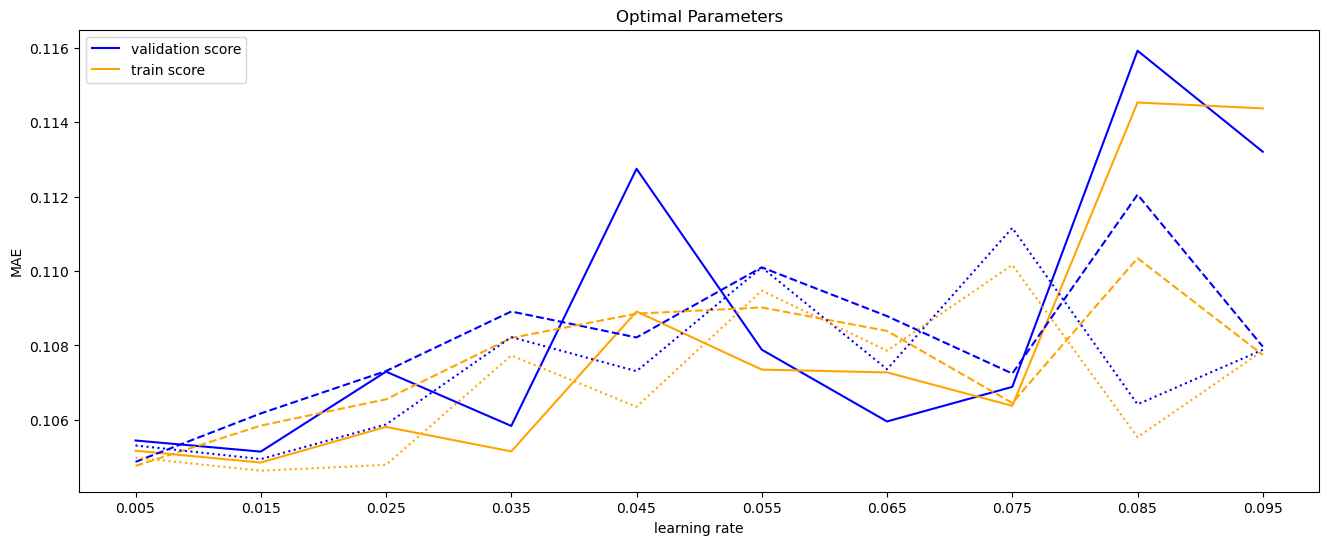

In [222]:

# plotting cv results
plt.figure(figsize=(16,6))
plt.plot(cv_results_none["param_eta0"], cv_results_none["mean_test_score"], color='blue', linestyle='solid')
plt.plot(cv_results_none["param_eta0"], cv_results_none["mean_train_score"], color='orange', linestyle='solid' )

plt.plot(cv_results_l1["param_eta0"], cv_results_l1["mean_test_score"], color='blue', linestyle='dashed')
plt.plot(cv_results_l1["param_eta0"], cv_results_l1["mean_train_score"], color='orange', linestyle='dashed')

plt.plot(cv_results_l2["param_eta0"], cv_results_l2["mean_test_score"], color='blue', linestyle='dotted')
plt.plot(cv_results_l2["param_eta0"], cv_results_l2["mean_train_score"], color='orange', linestyle='dotted')

plt.xticks(eta_lst)
plt.xlabel('learning rate')
plt.ylabel('MAE')
plt.title("Optimal Parameters")
plt.legend(['validation score', 'train score'], loc='upper left')

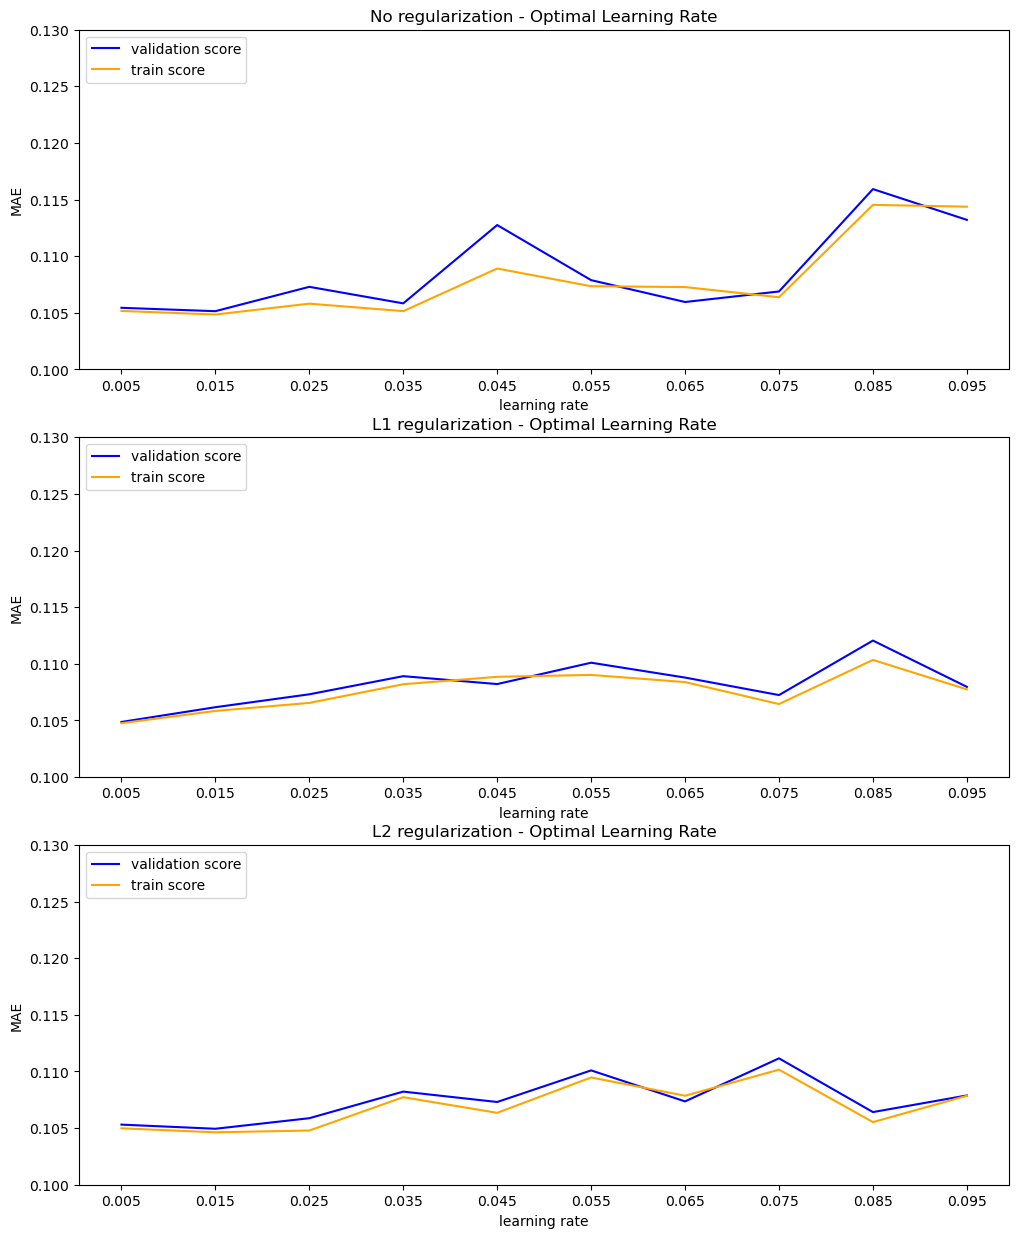

In [223]:
# plotting cv results
plt.figure(figsize=(12,15))

plt.subplot(3,1,1)
plt.plot(cv_results_none["param_eta0"], cv_results_none["mean_test_score"], color='blue')
plt.plot(cv_results_none["param_eta0"], cv_results_none["mean_train_score"], color='orange' )
plt.xticks(eta_lst)
plt.ylim([0.1,0.13])
plt.xlabel('learning rate')
plt.ylabel('MAE')
plt.title("No regularization - Optimal Learning Rate")
plt.legend(['validation score', 'train score'], loc='upper left')

plt.subplot(3,1,2)
plt.plot(cv_results_l1["param_eta0"], cv_results_l1["mean_test_score"], color='blue')
plt.plot(cv_results_l1["param_eta0"], cv_results_l1["mean_train_score"], color='orange')
plt.xticks(eta_lst)
plt.ylim([0.1,0.13])
plt.xlabel('learning rate')
plt.ylabel('MAE')
plt.title("L1 regularization - Optimal Learning Rate")
plt.legend(['validation score', 'train score'], loc='upper left')

plt.subplot(3,1,3)
plt.plot(cv_results_l2["param_eta0"], cv_results_l2["mean_test_score"], color='blue')
plt.plot(cv_results_l2["param_eta0"], cv_results_l2["mean_train_score"], color='orange')
plt.xticks(eta_lst)
plt.ylim([0.1,0.13])
plt.xlabel('learning rate')
plt.ylabel('MAE')
plt.title("L2 regularization - Optimal Learning Rate")
plt.legend(['validation score', 'train score'], loc='upper left')

plt.show()

In [225]:
np.min(cv_results_none["mean_train_score"])

0.10484942572774839

In [227]:
min_train_none = cv_results_none.loc[cv_results_none["mean_train_score"]==np.min(cv_results_none["mean_train_score"])]
min_train_none[['params', 'mean_train_score', 'mean_test_score']]

params  mean_train_score  mean_test_score
3  {'eta0': 0.015, 'penalty': 'None'}          0.104849         0.105144

In [228]:
min_test_none = cv_results_none.loc[cv_results_none["mean_test_score"]==np.min(cv_results_none["mean_test_score"])]
min_test_none[['params', 'mean_train_score', 'mean_test_score']]

params  mean_train_score  mean_test_score
3  {'eta0': 0.015, 'penalty': 'None'}          0.104849         0.105144

In [229]:
min_train_none = cv_results_l1.loc[cv_results_l1["mean_train_score"]==np.min(cv_results_l1["mean_train_score"])]
min_train_none[['params', 'mean_train_score', 'mean_test_score']]

params  mean_train_score  mean_test_score
1  {'eta0': 0.005, 'penalty': 'l1'}          0.104759         0.104868

In [230]:
min_test_l1 = cv_results_l1.loc[cv_results_l1["mean_test_score"]==np.min(cv_results_l1["mean_test_score"])]
min_test_l1[['params', 'mean_train_score', 'mean_test_score']]

params  mean_train_score  mean_test_score
1  {'eta0': 0.005, 'penalty': 'l1'}          0.104759         0.104868

In [231]:
min_train_l2 = cv_results_l2.loc[cv_results_l2["mean_train_score"]==np.min(cv_results_l2["mean_train_score"])]
min_train_l2[['params', 'mean_train_score', 'mean_test_score']]

params  mean_train_score  mean_test_score
5  {'eta0': 0.015, 'penalty': 'l2'}          0.104629         0.104942

In [232]:
min_test_l2 = cv_results_l2.loc[cv_results_l2["mean_test_score"]==np.min(cv_results_l2["mean_test_score"])]
min_test_l2[['params', 'mean_train_score', 'mean_test_score']]

params  mean_train_score  mean_test_score
5  {'eta0': 0.015, 'penalty': 'l2'}          0.104629         0.104942

In [233]:
sgd_reg = SGDRegressor(loss = 'squared_error', learning_rate = 'constant', eta0 = 0.015, penalty = 'l2')
sgd_reg.fit(X_train, y_train)
sgd_pred = sgd_reg.predict(X_train)

print('MAE:', metrics.mean_absolute_error(y_train, sgd_pred))
print('MSE:', metrics.mean_squared_error(y_train, sgd_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, sgd_pred)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, sgd_pred))
print('R2:', metrics.r2_score(y_train, sgd_pred))

MAE: 0.1039082072190821
MSE: 0.017443546469723882
RMSE: 0.13207401890502113
MAPE: 161449975154.46817
R2: 0.3605046937945916


In [235]:
sgd_pred_test = sgd_reg.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, sgd_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, sgd_pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, sgd_pred_test)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, sgd_pred_test))
print('R2:', metrics.r2_score(y_test, sgd_pred_test))

MAE: 0.09828974055819856
MSE: 0.01587538583628565
RMSE: 0.12599756281883254
MAPE: 0.42792351075602475
R2: 0.3801223147590833


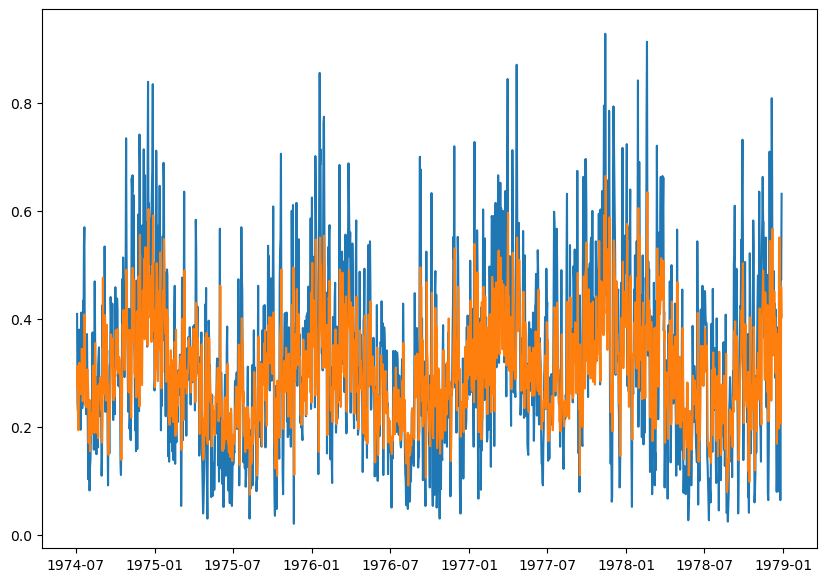

In [238]:
y_hat = pd.Series(sgd_pred_test, index=y_test.index)


plt.figure(figsize=(10,7))
plt.plot(y_test)
plt.plot(y_hat)
plt.show()